# Spatial Lag

This python notebook introduces the concept of spatial lag for **spatial autocorrelation**, using the [`lag_spatial` function](https://pysal.org/libpysal/generated/libpysal.weights.lag_spatial.html) from PySAL. It uses an example previously presented by [Rey *et al.* (2020)](https://geographicdata.science/book/notebooks/06_spatial_autocorrelation.html#spatial-lag) and data therein. The example presented here shows how spatial lag can be interpreted as the average (mean) value of a focal location's neighbours.

## Concept
Used with spatial weights matrices, the spatial lag operator is an important element of many spatial analysis techniques. For example it is used when calculating, interpreting and visualising local Moran's $I$ (a common quantitative measure of spatial autocorrelation, covered in detail in another notebook). 

The spatial lag operator can be expressed as:

$$
y_{sl-i} = \sum_j w_{ij} y_j
$$

where:

- $y$ is the variable of interest, 
- $i$ and $j$ are locations in space, 
- and $w_{ij}$ is the value of a spatial weights matrix for the relationship between locations $i$ and $j$. 

Assuming that non-neighbours receive a weight of zero, $y_{sl-i}$ is the product (multiplication) of $y$ values and weights for $i$’s neighbours. 

Thus, spatial lag operator essentially smoothes the values of a variable across space. For example, if a row-standardised spatial weights matrix is used, the effect of the operator is to produce spatially lagged local mean values of a variable. 

To understand this concept concretely with real world data, we'll look at the results of the UK Brexit vote (as presented in [Rey *et al.* 2020](https://geographicdata.science/book/notebooks/06_spatial_autocorrelation.html#an-empirical-illustration-the-eu-referendum)).

As [provided](https://geographicdata.science/book/data/brexit/brexit_cleaning.html) by Rey *et al.* (2020), there are two distinct datasets that will need to be loaded and combined:

- Electoral Comission data on vote percentages at the local authority level. [CSV]
- ONS Local Authority Districts (December 2016) Generalised Clipped Boundaries in the UK WGS84. [geojson]

## Setup

Import required libraries

In [1]:
# Graphics
import matplotlib.pyplot as plt

# Analysis
import geopandas as gpd
import pandas as pd
from pysal.lib import weights

Load the vote percentage data as a pandas df:

In [2]:
brexit_data_path = 'data/brexit/brexit_vote.csv'
ref = pd.read_csv(brexit_data_path, index_col='Area_Code')
ref.head()

,id,Region_Code,Region,Area,Electorate,ExpectedBallots,VerifiedBallotPapers,Pct_Turnout,Votes_Cast,Valid_Votes,Remain,Leave,Rejected_Ballots,No_official_mark,Voting_for_both_answers,Writing_or_mark,Unmarked_or_void,Pct_Remain,Pct_Leave,Pct_Rejected
Area_Code,,,,,,,,,,,,,,,,,,,,
E06000031,108,E12000006,East,Peterborough,120892,87474,87469,72.35,87469,87392,34176,53216,77,0,32,7,38,39.11,60.89,0.09
E06000032,109,E12000006,East,Luton,127612,84633,84636,66.31,84616,84481,36708,47773,135,0,85,0,50,43.45,56.55,0.16
E06000033,112,E12000006,East,Southend-on-Sea,128856,93948,93939,72.90,93939,93870,39348,54522,69,0,21,0,48,41.92,58.08,0.07
E06000034,113,E12000006,East,Thurrock,109897,79969,79954,72.75,79950,79916,22151,57765,34,0,8,3,23,27.72,72.28,0.04
E06000055,110,E12000006,East,Bedford,119530,86136,86136,72.06,86135,86066,41497,44569,69,0,26,1,42,48.22,51.78,0.08


Next load the local authority district boundaries as a geopandas geodf:

In [3]:
lads = gpd.read_file("data/brexit/local_authority_districts.geojson").set_index('lad16cd')
lads.head()

,objectid,lad16nm,lad16nmw,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry
lad16cd,,,,,,,,,,
E06000001,1,Hartlepool,None,447157,531476,-1.27023,54.676159,0.013041,0.879421,"MULTIPOLYGON (((-1.27024 54.72716, -1.38088 54..."
E06000002,2,Middlesbrough,None,451141,516887,-1.21099,54.544670,0.007484,0.535764,"MULTIPOLYGON (((-1.23001 54.58410, -1.28158 54..."
E06000003,3,Redcar and Cleveland,None,464359,519597,-1.00611,54.567520,0.034014,1.266847,"MULTIPOLYGON (((-1.13716 54.64693, -1.13256 54..."
E06000004,4,Stockton-on-Tees,None,444937,518183,-1.30669,54.556911,0.028479,1.424195,"MULTIPOLYGON (((-1.31774 54.64524, -1.38088 54..."
E06000010,10,"Kingston upon Hull, City of",None,511894,431716,-0.30380,53.769791,0.009740,0.782168,"MULTIPOLYGON (((-0.31613 53.81325, -0.35366 53..."


And then `join` the df to the geodf (the two df have the same index, using local autority district codes) and select only the columns we need for the analysis:

In [4]:
gdf = gpd.GeoDataFrame(lads.join(ref[['Pct_Leave']]), crs=lads.crs)
gdf = gdf[['objectid', 'lad16nm', 'Pct_Leave', 'geometry']].dropna()
gdf.head()

,objectid,lad16nm,Pct_Leave,geometry
lad16cd,,,,
E06000001,1,Hartlepool,69.57,"MULTIPOLYGON (((-1.27024 54.72716, -1.38088 54..."
E06000002,2,Middlesbrough,65.48,"MULTIPOLYGON (((-1.23001 54.58410, -1.28158 54..."
E06000003,3,Redcar and Cleveland,66.19,"MULTIPOLYGON (((-1.13716 54.64693, -1.13256 54..."
E06000004,4,Stockton-on-Tees,61.73,"MULTIPOLYGON (((-1.31774 54.64524, -1.38088 54..."
E06000010,10,"Kingston upon Hull, City of",67.62,"MULTIPOLYGON (((-0.31613 53.81325, -0.35366 53..."


Let's quickly visualise the vote percentage data:

<AxesSubplot:>

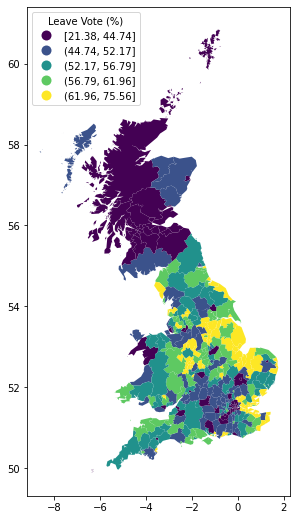

In [5]:
fig, ax = plt.subplots(1, figsize=(9, 9))
gdf.plot(column='Pct_Leave', 
    cmap='viridis', scheme='quantiles', k=5, 
    linewidth=0., legend=True, legend_kwds={"title":'Leave Vote (%)',"loc": 2},
    ax=ax
)

To more easily visualise the local smoothing (averaging) effect of the spatial lag operator, we'll use the following function to enable us to zoom into particular locations across the UK.

In [6]:
def plotLeaveLocation(axes, idx, var, xlim_coords, ylim_coords):

    gdf.plot(column=var, 
        cmap='viridis', scheme='quantiles', k=5,
        linewidth=0., legend=True, legend_kwds={"title":var,"loc": 2},
        ax=axes
    )

    gdf.loc[[idx]].plot(ax=axes, color='none', edgecolor='black', linewidth=3)

    axes.set_xlim(xlim_coords)
    axes.set_ylim(ylim_coords) 
    axes.set_title(gdf.loc[idx]['lad16nm'])
    #plt.show()

## Application

In this example we will compare the Local Authority Districts (LADs) of Liverpool and Midlothian (i.e. Edinburgh). 

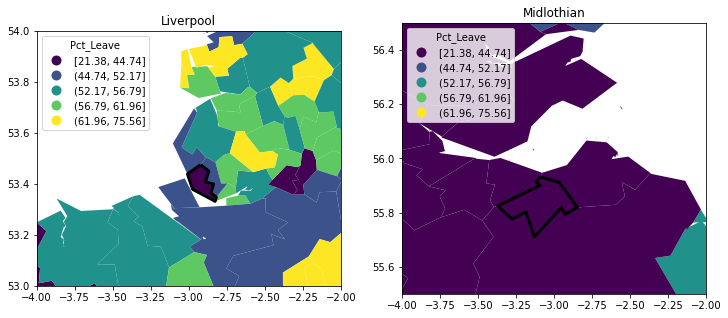

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12, 9))

plotLeaveLocation(ax[0], 'E08000012', 'Pct_Leave', xlim_coords=(-4,-2), ylim_coords=(53,54))
plotLeaveLocation(ax[1], 'S12000019', 'Pct_Leave', xlim_coords=(-4,-2), ylim_coords=(55.5,56.5))


In [8]:
gdf.loc[['E08000012', 'S12000019'], 
       ['lad16nm','Pct_Leave']]

,lad16nm,Pct_Leave
lad16cd,,
E08000012,Liverpool,41.81
S12000019,Midlothian,37.94


From the maps and table above you should be able to see that these LADs had similar Vote Leave % in the Brexit vote. But the maps also show that the distribution of leave vote % of their neighbours differs noticeably; while Liverpool is surrounded by neighbours that have *higher* leave vote %, Midlothian is surrounded by by neighbours that have *lower* leave vote %. Thus, the spatial context of the LADs is different. It is this spatial context that the spatial lag operator measures, and so we should be able to see differences in the spatial lag for these two LADs. 

First we need to create a spatial weights matrix for our data. We'll use K Nearest Neighbours, with `k=8`:

In [9]:
# Generate W from the GeoDataFrame
w = weights.KNN.from_dataframe(gdf, k=8)
w.full()[0]

array([[0., 1., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Next we row-standarize the weights. This is a common transformation; for example, Moran's $I$ uses row-standarized weights. 

Row-standardization means *add all the weights in a row and divides by the number of neighbours*. This ensures the sum of all values of each row equals 1. 

Here we have 8 neighbours, so there will be 8 non-zero weights in each row. In turn, this means row-standarization will change all our all weights to 0.125 (1 divided by 8):

In [10]:
w.transform = 'R'
w.full()[0]

array([[0.   , 0.125, 0.125, ..., 0.   , 0.   , 0.   ],
       [0.125, 0.   , 0.125, ..., 0.   , 0.   , 0.   ],
       [0.125, 0.125, 0.   , ..., 0.   , 0.   , 0.   ],
       ...,
       [0.   , 0.   , 0.   , ..., 0.   , 0.125, 0.   ],
       [0.   , 0.   , 0.   , ..., 0.125, 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ]])

The effect of row-standardising the weights matrix is for the spatial lag operator to measure the spatially lagged mean values of each location (i.e. the mean of the focal location's neighbours' values). 

Think about why this is; the mean is calculated by adding all values and dividing by the number of values. In this case the values are those of the focal location's neighbours. Assuming the eight neighbours have values 1-8 (of some variable) we get:

$$ 
\frac{(1 + 2 + 3 + 4 + 5 + 6 + 7 + 8)}{8} = \frac{36}{8} = 4.5
$$

Multiplying standardised weights by neighbours' observed values and then summing does essentially the same thing (and gets exactly the same result): 

$$((1\times0.125) + (2\times0.125) + (3\times0.125) + (4\times0.125) + (5\times0.125) + (6\times0.125) + (7\times0.125) + (8\times0.125))$$

which is:

$$0.125 + 0.25 + 0.375 + 0.5 + 0.625 + 0.75 + 0.875 + 1 = 4.5$$

With our row-standardized weights matrix, we now calculate the lagged values using the [lag_spatial](https://pysal.org/libpysal/generated/libpysal.weights.lag_spatial.html) function:

In [11]:
gdf['Pct_Leave_lag'] = weights.spatial_lag.lag_spatial(w, gdf['Pct_Leave'])

Let's compare the original vote leave % values for our LADs of interest with their spatially lagged local mean values:

In [12]:
gdf.loc[['E08000012', 'S12000019'], 
       ['lad16nm','Pct_Leave', 'Pct_Leave_lag']]

,lad16nm,Pct_Leave,Pct_Leave_lag
lad16cd,,,
E08000012,Liverpool,41.81,53.22375
S12000019,Midlothian,37.94,38.91625


Remember how in the maps above we saw that Liverpool was surrounded by neighbours with generally *higher* leave vote %, while Midlothian was surrounded by by neighbours that have *lower* leave vote %. This is now shown in the spatially lagged value calculated for each LAD, which is much higher for Liverpool than for Midlothian. 

And we can now map these spatially lagged vote leave % for *all* LADs: 

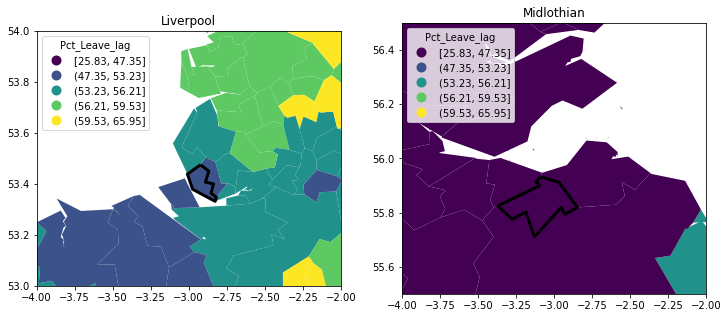

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12, 9))

plotLeaveLocation(ax[0], 'E08000012', 'Pct_Leave_lag', xlim_coords=(-4,-2), ylim_coords=(53,54))
plotLeaveLocation(ax[1], 'S12000019', 'Pct_Leave_lag', xlim_coords=(-4,-2), ylim_coords=(55.5,56.5))

Note how the map for Liverpool has changed much more than the map for Midlothian. The original map for Liverpool was much more spatially hetergenous (i.e. varied) then the original map for Midlothian. Hence the map of spatially lagged (local mean) values for Liverpool has become smoother compared to its original than the map for Midlothian, which was originally already quite homogenous (i.e. smooth). 

And we can see the effect on the entire UK:

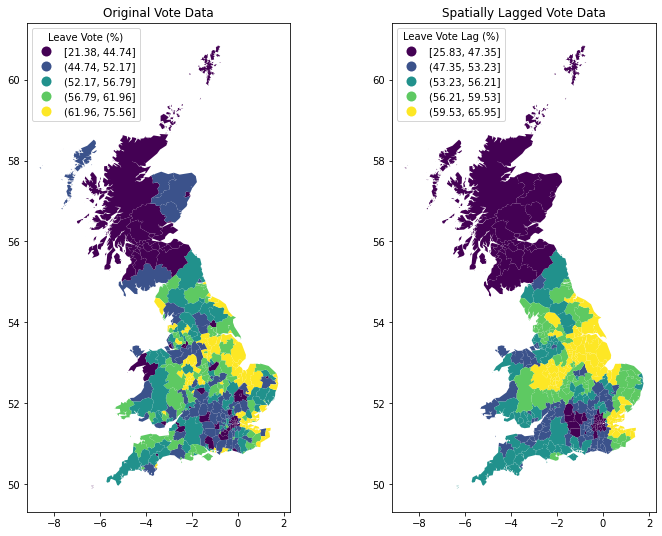

In [14]:
fig, axes = plt.subplots(1,2, figsize=(12, 9))
gdf.plot(column='Pct_Leave', 
    cmap='viridis', scheme='quantiles', k=5, 
    linewidth=0., legend=True, legend_kwds={"title":'Leave Vote (%)',"loc": 2},
    ax=axes[0]
)
axes[0].set_title("Original Vote Data")

gdf.plot(column='Pct_Leave_lag', 
    cmap='viridis', scheme='quantiles', k=5, 
    linewidth=0., legend=True, legend_kwds={"title":'Leave Vote Lag (%)',"loc": 2},
    ax=axes[1]
)
axes[1].set_title("Spatially Lagged Vote Data")
plt.show()

Hopefully you can see the spatially lagged map has less spatial variation (i.e. is 'smoother') than the original data. 

# Credits!

## Contributors:
The following individual(s) have contributed to these teaching materials: James Millington (james.millington@kcl.ac.uk).

## License
These teaching materials are licensed under a mix of [The MIT License](https://opensource.org/licenses/mit-license.php) and the [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 license](https://creativecommons.org/licenses/by-nc-sa/4.0/).